# Временные ряды 3. 

# Моделируем временные ряды по ARIMA

Стационарные и нестационарные модели временных рядов требуют отдельного анализа. Отделить стационарную часть от нестационарной можно за счет правильного выбора параметров сглаживания и представления модели в виде суммы (или иногда произведения) стационарных и нестационарных частей ряда. Вопрос дня - как определить параметры сглаживания и как предсказывать стационарную часть ряда.

Пока наш алгоритм обработки ряда преодолел 2 основных этапа:
- визуализация и зачистка от проблем
- анализ характера ряда как стационарного или нестационарного

Попробуем понять, что нужно делать, что бы построить наконец модель во времени с учетом всего вместе. Вернемся к нашим рядам: "Потребление энергии" и "Цена нефти BRENT". Будем использовать предобработанные версии этих рядов с признаками из календаря.   




## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Описательная статистика практически не изменилась после обработки пропусков, сортировки и удаления дублей.

In [3]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


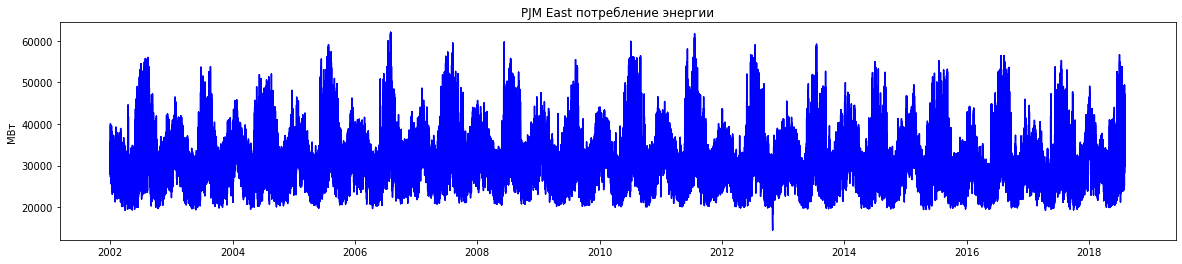

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [5]:

#path_brent = 'brent_cl_m5_20120101_20121231.csv'
#brent_data['Значение'] =brent_data['CLOSE']
#brent_data = pd.read_csv(path_brent,sep = ';', index_col=[0], parse_dates=[0])
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Основные статистики ряда остались без изменений.

In [6]:
brent_data.describe()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,2667.000000,2667.000000,2667.00000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,81.533547,2014.661042,6.51706,15.715786,2.505062,182.901762,26.486689,2.537308,0.027747,0.026997,0.029621
std,26.349469,2.663525,3.43026,8.780275,1.112684,104.741067,14.935147,1.894937,0.164277,0.162104,0.169572
min,27.850000,2010.000000,1.00000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,56.840000,2012.000000,4.00000,8.000000,2.000000,92.000000,14.000000,1.000000,0.000000,0.000000,0.000000
50%,77.710000,2015.000000,7.00000,16.000000,3.000000,183.000000,27.000000,2.000000,0.000000,0.000000,0.000000
75%,108.190000,2017.000000,9.00000,23.000000,3.000000,273.000000,39.000000,4.000000,0.000000,0.000000,0.000000
max,126.900000,2019.000000,12.00000,31.000000,4.000000,366.000000,53.000000,6.000000,1.000000,1.000000,1.000000


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

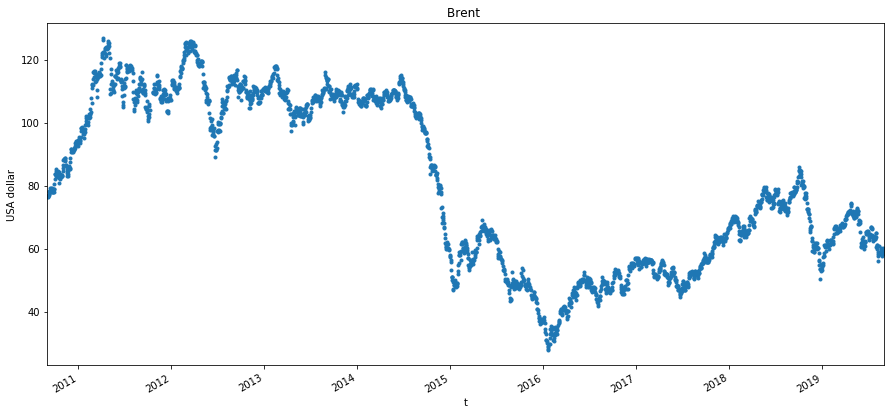

In [7]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Рис.3 Цена нефти с 2010 по 2019

Сравним два примера "Почасовое потребление энергии" и "подневные цены на нефть":


Характер этих рядов существенно отличается. Энергия имеет выраженный порядок смены сезонов (рис.1) и дня и ночи (рис.2). Тогда как цена нефти не показывает никакой подобной динамики (Рис.3). Связать цены на нефть с календарем на этом этапе анализа не удалось. Это видно, по не очень впечатляющим результатам моделирования цены нефти (Временные ряды. часть 1 и 2).

В обеих последовательностях есть необычные артефакты: выброс 2012.10 в потреблении энергии и провал цены на нефть в 2014(природу которого нужно изучать).

Попробуем определить параметры модели для этих примеров.

### Методы анализа рядов

При построении моделей временных рядов обычно говорят о следующих типах моделей:
- статистические, где зависимость будущего значения от прошлого задается в виде некоторого уравнения, а их делят на регрессионные модели (линейная регрессия, нелинейная регрессия), авторегрессионные модели (ARIMAX), модель экспоненциального сглаживания и т.д. Эта форма описания ряда содержит представление о формуле с параметрами, которые хорошо обходят точки соответствующие прошлому и, наверное, будут хорошо описывать будущее. 
- структурные модели, где зависимость будущего значения от прошлого задается в виде некоторой структуры и правил перехода по ней. К ним относят нейросетевые модели, модели на базе цепей Маркова, модели на базе классификационно-регрессионных деревьев и т.д.
- спектральные модели, которые основаны на определении временного ряда как совокупности простых процессов разной частоы.

Таким образом, возвращаясь к объектам реального мира для статистических моделей, если наш кот бегает за игрушкой и нам известна масса и размер котенка, а так же на основании предшествующих измерений нам удалось оценить корреляцию возраста, размера и массы котенка с его скоростью и маневренностью, то мы сможем предсказать, как быстро будет бегать питомец в будующем.  
С другой стороны модели на основе методов обучения, предполагают, что связь доступных для измерения свойств объекта или предшествующих значений ряда можно получить, если взять достаточно сложную функцию с параметрами и адаптировать(обучить) эти параметры опираясь на известные примеры. Близкие идеи реализует и спектральная модель описания явлений, т.к. ее задача состоит в подборе(вычислении) амплитуд простых процессов, из которых будем складывать описание прошлого.

Все подходы к моделированию рядов объединяет предположение, что будущее в некоторой степени зависит (и повторяе) прошлое. 

Перейдем к рассмотрению способов описания рядов на формальном уровне. По форме можно выделить две основных модели :
- аддитивная :  y(y) = X_trend(t) + X_cicle(t) + e(t)
- мультипликативная :  y(y) = X_trend(t) X_cicle(t) e(t)

Здесь y(y) - изменение значений ряда по времени, X_trend(t) - трендовая составляющая, X_cicle(t) - циклическая с оставляющая и случайная часть e(t) ряда.
Разница между ними состоит в способе учета факторов влияющих на общее решение.

Рассмотрим вариант решения задачи описания временного ряда в форме модели ARIMA (статистическая форма анализа ряда) на базе пакета statsmodels http://www.statsmodels.org/dev/tsa.html.

In [8]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


ARMA - Авторегрессионная модель скользящего среднего. В области анализа временных рядов модель авторегрессии (autoregressive, AR) и модель скользящего среднего (moving average, MA) является сравнительно простой и оперирует 2-мя параметрами: глубиной регрессии - р и длиной скользящего среднего - q. Чем больше q - тем больше сглаживание ряда (для нефти и Потребления энергии мы их примерно определили в процессе ресемплинга на разные интервалы).

ARIMA - Интегрированная Авторегрессионная модель скользящего среднего, построенна для ряда первых разностей. Определяется на 3-х параметрах : p — порядок компоненты AR, d — порядок интегрированного ряда, q — порядок компонетны MA.


ARIMA импортируется по: 
    from statsmodels.tsa.arima_model import ARIMA

Строим ARIMA модель:
    model = ARIMA(data, order=(1, 1, 1)), где
     order - порядок модели в формате (p,d,q)
     data - собственно ряд в форме numpy массива
Построим модель по нашему объекту model через обращение к методу fit:
    model_fit = model.fit(disp=False)

Посмотрим , что построилось на старых данных:
    y_p = model_fit.predict(len(data), len(data), typ='levels')

или предскажем новые , начиная от последней точки ряда n новых точек :
    y_f =model_fit.forecast(n), где y_f - содержит 3 массива y_f[0] - основное предсказание, y_f[1] - оценка ошибки и y_f[2] 2-х мерный массив границ доверительного интервала
    
    Для примера возьмем искусственную модель сигнала в составе : тренд - х*3, цикл 5*np.sin(x/20) и стационарная составляющая 5*random(). Таким образом, есть стационарная и нестационарная части ряда. Посмотрим как его смоделировать в ARIMA.

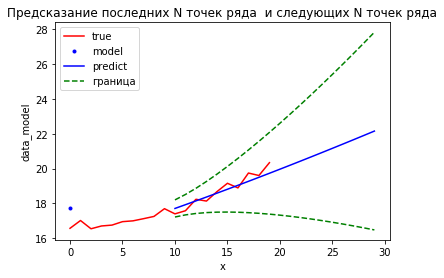

In [9]:
# ARIMA пример
from statsmodels.tsa.arima_model import ARIMA
from random import random
# модельный ряд
np.random.seed(21)
data_model = [x*0.3 +10*np.sin(x/20) + 0.7*np.random.random(1) for x in range(1, 100)]
N=10    # число точек для теста
# строим модель
model = ARIMA(data_model[:-N], order=(1, 1, 2))
model_fit = model.fit(disp=False)
# делаем оценку старых значений
y_p = model_fit.predict(len(data_model[:-N]), len(data_model[:-N]), typ='levels')
y_f = model_fit.forecast(2*N)
plt.plot(data_model[-10-N:],'r',label ='true')
plt.plot(y_p,'.b',label ='model')
plt.plot(np.arange(2*N)+N,y_f[0],'b',label ='predict')
plt.plot(np.arange(2*N)+N,y_f[2][:,1],'--g', label = 'граница')
plt.plot(np.arange(2*N)+N,y_f[2][:,0],'--g')
plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

Сформированная модель устанавливает параметр p=1, d=1 и q=2. Понятно, что получение параметров модели потребовало какого-то анализа поведения ряда. И вообще говоря, модель будет работать для довольно большого диапазона параметров. Наша задача выбрать правильный тип модели сглаживания и определить какие составляющие ряда актуальны именно для нашего случая. Основные варианты описываются двумя моделями ARIMA и SARIMAX. Первый тип моделей не учитывает сезонные циклы, а второй их обработает. Дальнейший анализ позволит включить или отключить составляющие модели (р=0 - нет скользящей средней, q=0 - нет экспоненциального сглаживания, d = 0 - модель без интегральной части). 

Варианты описания задач моделирования временных рядов в statsmodels можно посмотреть в  https://www.machinelearningmastery.ru/time-series-forecasting-methods-in-python-cheat-sheet/ и документации модуля (ссылка выше)

Итак, необходимо определить значения ARIMA (p, d, q) (текущие) и (P, D, Q) s(сезонные для SARIMAX ) параметры модели, которые оптимизируют точность соответствия модели истинной ситуации. 

Правильная параметризация моделей ARIMA вручную —  процесс довольно кропотливый, требует изучения предметной обрласти и занимает много времени. Посмотрим на инструменты и методы подбора параметров модели ARIMA(SARIMAX). 

**Определим параметры ARIMA**. 

Для этого используем ACF (определит q) и PACF (определит p)

ACF - автокорреляционная функция, по коррелограмме которой можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA. 

PACF - автокорреляционная функция первых разностей, по коррелограмме которой можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR. 

Построим такие коррелограммы из statsmodels по функциям plot_acf() и plot_pacf(). Графики ACF и PACF, где по оси X откладываются номера лагов, а по оси Y значения соответствующих функций.

Для скорости и удобства отображения посмотрим на более простых данных - ресемплингах исходного ряда на дневные(data_d), месячные (data_m), недельные (data_w) и 3-х месячные ряды(data_Y)

In [10]:
data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

In [ ]:
type(data['PJME_MW'])

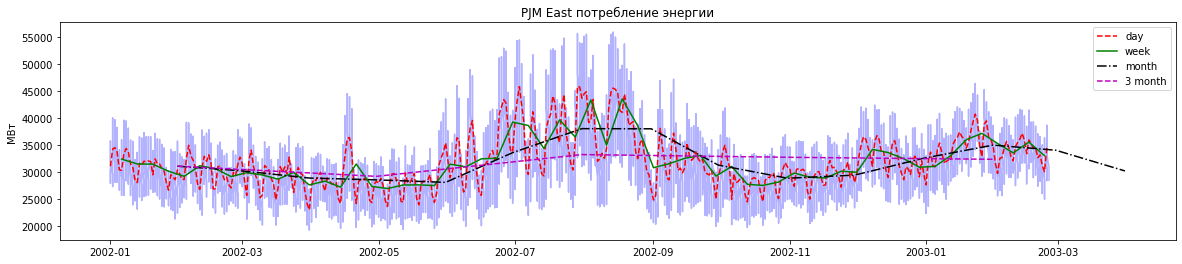

In [12]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

Но сначала посмотрим , что можно увидеть для исходной модели (работает очень долго)

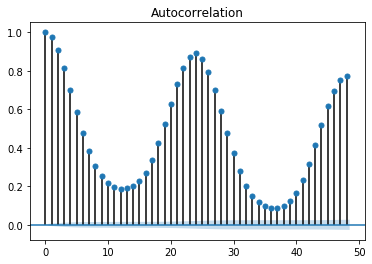

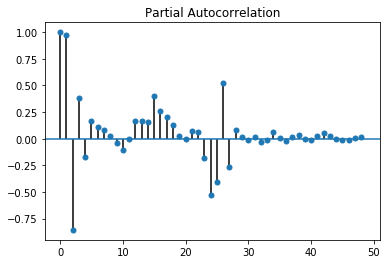

In [13]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=24*2)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=24*2)
plt.show()

Получили оценку автокорреляции часовой модели по иcходному ряду и его первым разностям. Для этой модели можно увидеть значительную автокорреляцию с лагом 24 часа(никто и не сомневался см.рис. Autocorrelation) и значительную корреляцию остатков по первым трем лагам (Partial Autocorrelation) с падением, но не нулевой корреляцией для лагов до 24 часов. Первый график говорит о параметре части MA(24) - т.е следует рассматривать ресемплинг модели (поскольку авторегрессия 24) на дневные модели. По второму графику можно сказать, что есть нестационарность и необходимо ее отделить от нашего ряда. Мы помним, что ADF нам эту нестационарность уже диагностировал (временные ряды 2). Посмотрим ресемплинг на дневные данные, т.е. сгладим наш ряд по упрощенной схеме.

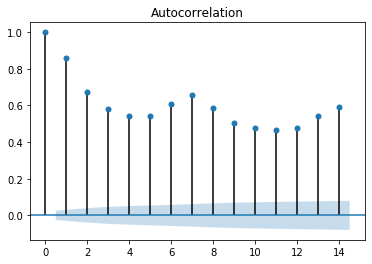

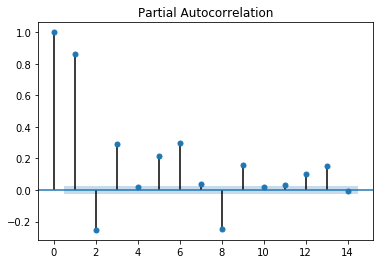

In [14]:
sm.graphics.tsa.plot_acf(data_d['PJME_MW'].values, lags=14)
plt.show()
sm.graphics.tsa.plot_pacf(data_d['PJME_MW'].values, lags=14)
plt.show()

Картина для дневных примеров имеет более общий вид, но тоже есть значительная автокорреляция по недельным лагам с медленным падением связи в течениии 2-х недель(ACF). Практически аналогично выглядит картинка и для разностей(PACF) т.е. есть значительная по 1-му остатку (AR 1) и более слабые связи по неделям (до AR 8 ). Посмотрим как выглядит ряд при ресемплинге на 3-месячных данных.

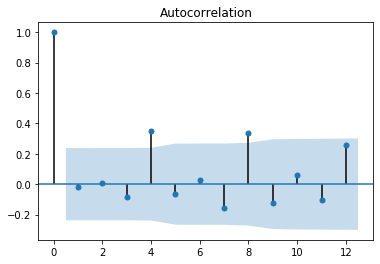

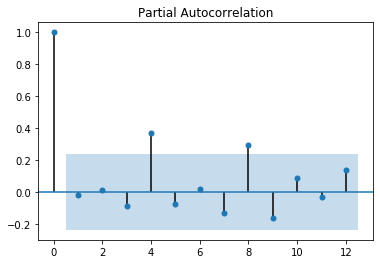

In [15]:
sm.graphics.tsa.plot_acf(data_Y['PJME_MW'].values, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(data_Y['PJME_MW'].values, lags=12)
plt.show()

На трехмесячном графике можно увидеть, что есть ежегодный цикл (лаг 4 и 8) для ACF (МА 4) и PACF (AR 4). Это годовые сезонные изменения по всем периоду наблюдений. Аналогичную картину можно увидеть для оценки автокорреляций на месячных данных:

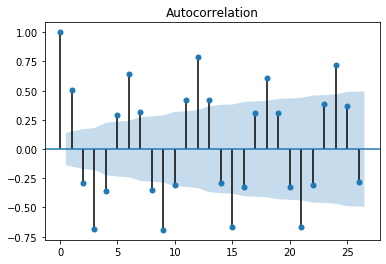

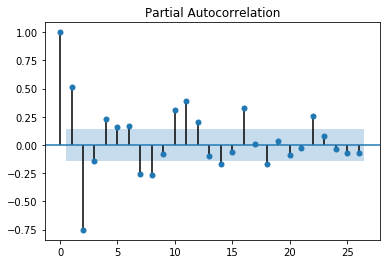

In [16]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.show()

Сохраняется корреляция для квартальных лагов (3, 6, 9 и 12 месяцы - это наши сезонные колебания - ACF) и для разностей важными являются значения внутри первых 3-х значений (PACF). Это позволит определить, что ряд сезонный и следует использовать модель сезонности с периодом 12, 6 или 3 месяца. диапазон поиска параметров модели ARIMA для лучшего описания нашего ряда в диапазоне до первых разностей и сглаживаний первого порядка. 

Рассмотрим результаты моделирования ряда с потенциально хорошими значениями порядками компонент нашего ряда с учетом сезонности в модификации SARIMAX, которая кроме всего прочего строит сезонную составляющую ряда. Фактичесски строим 3 модели : модель сезона и модель вокруг сезонных колебаний. А наш ряд очевидно сезонный. В качестве метрики качества используем информационный критерий Акаике (AIC) - чем меньше, тем лучше.

Обозначения для модели включают указание порядка для моделей AR (p), I (d) и MA (q) в качестве параметров функции ARIMA и AR (P), I (D), MA (Q) и m. параметры на сезонном уровне, например SARIMA (p, d, q) (P, D, Q) m, где «m» - количество временных шагов в каждом сезоне (сезонный период). Модель SARIMA может использоваться для разработки моделей AR, MA, ARMA и ARIMA. Принципиально формат обращения остается прежним (как у ARIMA), за исключением добавки сезонных параметров SARIMAX(<данные - массив ряда>,order=[p,d,q], seasonal_order=[ps,ds,qs])

In [ ]:
import warnings

# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с месячными данными, тогда сезонность это 12 месяцев
qs = 1
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs, 26] 


In [18]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [0, 1, 1, 26]


In [ ]:
#для построения модели используем все данные, кроме 12-х последних недель (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


In [20]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  854
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 26)   Log Likelihood               -7412.182
Date:                            Mon, 25 May 2020   AIC                          14834.364
Time:                                    10:41:44   BIC                          14857.769
Sample:                                         0   HQIC                         14843.357
                                            - 854                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Анализ результатов по results:
- коэффициенты при элементах модели имеют большие значения (особенно важны составляющие сглаживания coef: ma.L1, ar.S.L3 , ma.S.L3)
- можно посмотреть на остатки ряда (results.resid) с точки зрения автокорреляции и убедиться, что они не имеют значительной корреляции (это хорошо, т.к. остатки имеют характер белого шума)

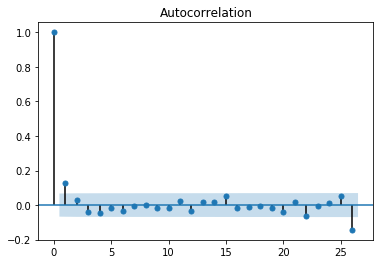

In [21]:
sm.graphics.tsa.plot_acf(results.resid, lags=26)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics: 
- левый верхний график - остатки ряда 
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

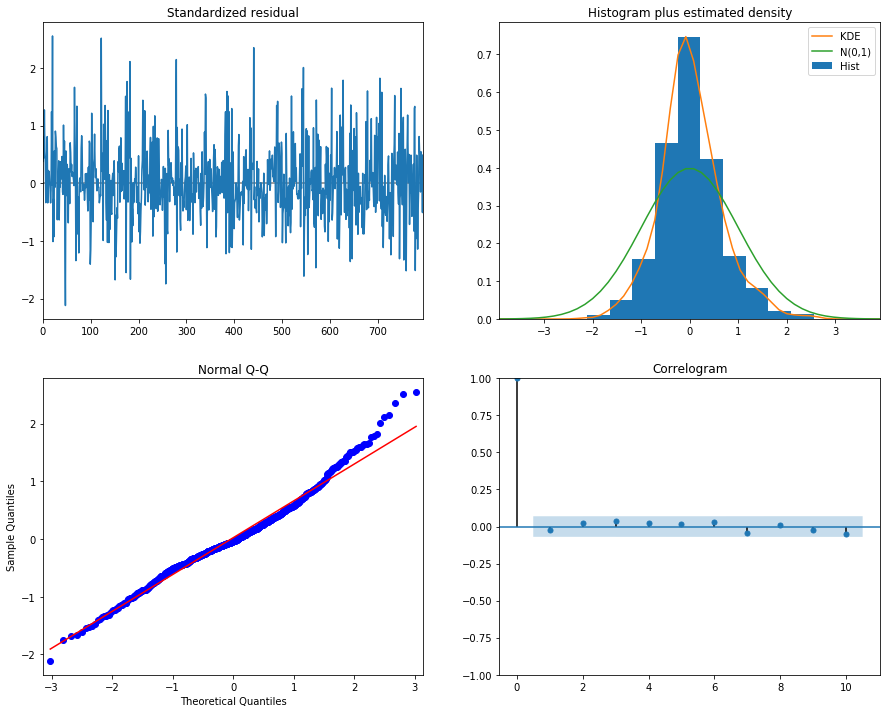

In [22]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


В этом случае диагностика показала, что остатки модели правильно распределяются:
- estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . Очевидно, что остатки нормально распределены.
- График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). Опять же, это признак того, что остатки нормально распределены.
- Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

Подобрать параметры модели можно используя сеточный выбор как это сделано для ряда "Потребление энергии" ниже (работает долго!):
    - На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда (для этой модели берем [0,3]).
    - задаем длину сезона (здесь 26 недель - зимой греем, летом кондиционируем и расход энергии примерно одинаковый)
    - Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов.
    - Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC.
    - Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной моделит

In [23]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 26)
SARIMAX: (0, 0, 1) x (0, 0, 2, 26)
SARIMAX: (0, 0, 2) x (0, 1, 0, 26)
SARIMAX: (0, 0, 2) x (0, 1, 1, 26)


In [ ]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 26)3 - AIC:19713.52774240997
ARIMA(0, 0, 0)x(0, 0, 1, 26)3 - AIC:18571.491231815064
ARIMA(0, 0, 0)x(0, 0, 2, 26)3 - AIC:17828.59933113616
ARIMA(0, 0, 0)x(0, 1, 0, 26)3 - AIC:15645.76456669608
ARIMA(0, 0, 0)x(0, 1, 1, 26)3 - AIC:14800.853569580282
ARIMA(0, 0, 0)x(0, 1, 2, 26)3 - AIC:14154.17224402896
ARIMA(0, 0, 0)x(0, 2, 0, 26)3 - AIC:16086.27728960583
ARIMA(0, 0, 0)x(0, 2, 1, 26)3 - AIC:14914.232056784342
ARIMA(0, 0, 0)x(0, 2, 2, 26)3 - AIC:14326.044541989173
ARIMA(0, 0, 0)x(1, 0, 0, 26)3 - AIC:15666.795756673966
ARIMA(0, 0, 0)x(1, 0, 1, 26)3 - AIC:15617.150626108614
ARIMA(0, 0, 0)x(1, 0, 2, 26)3 - AIC:14683.33987880359
ARIMA(0, 0, 0)x(1, 1, 0, 26)3 - AIC:14614.57022071864
ARIMA(0, 0, 0)x(1, 1, 1, 26)3 - AIC:14588.612436896508
ARIMA(0, 0, 0)x(1, 1, 2, 26)3 - AIC:14068.336512330641
ARIMA(0, 0, 0)x(1, 2, 0, 26)3 - AIC:14733.414398420313
ARIMA(0, 0, 0)x(1, 2, 1, 26)3 - AIC:14642.996100894085
ARIMA(0, 0, 0)x(1, 2, 2, 26)3 - AIC:14007.89484163196
ARIMA(0, 0, 0)x(2,

Лучшие результаты на недельных данных параметры модели SARIMA(0,0, 1)x(1, 1, 2, 26) - AIC:14254.93 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

In [ ]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[:-12],order=[0,0,1],
                                seasonal_order=[1,1,2,26] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)


Проведем моделирование прогноза на основе найденой SARIMAX[1, 2, 2]x[0, 1, 1, 26] - AIC:14834.36 и модели  SARIMA(0, 0, 1)x(1, 1, 2, 26) для последних 12 дней(и предсказание следующих 30 )  и сравним их с фактом.

In [ ]:
pred_dynamic = results.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_w['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

Видно, что предсказание новых точек тем слабее, чем дальше от последней известной точки ряда. Это можно объяснить тем, что накапливается ошибка предсказания или изменились условия развития ряда (наш котенок перестанет когда-нибудь расти и следовательно его скорость и маневренность долгое время не будут изменяться). Кроме того, модель, которую выбрали по сетке, заметно лучше обходит точки известные нам заранее и имеет более схожный характер.Таким образом, подбор позволил улучшить исходный результат для ряда с сезонами и циклами. 

Повторим процесс для второго ряда "Цена нефти Brent" и посмотрим на особенности моделирования такого ряда. Напомним, что нет сезонности, есть интегральность, есть изменяющиеся во времени тенденции (временные ряды 2).

In [ ]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(brent_data['Значение'].values, lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_data['Значение'].values, lags=30)
plt.show()

Дневные графики показывают автокорреляцию цены со всеми значениями ранее (это не очень хорошо) и для на PACF мы видим, что только 1-й порядок разностей важен для нашего процесса (AR 1). Это полностью согласуется с проведеным ранее анализом. Запустим модель бесз сезонного анализа (ARIMA)

In [ ]:
# Определим p, d и q 
q = 0
p = 0
d = 1
pdq = [p, d, q]


warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(brent_data['Значение'].values[:-30],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

Коэффициент модели  ma.L1  и ar.L2 имеет малое абсолютное значение, что свидетельствует о том, что он не играет роли при определении ответа модели. посмотрим на визуализацию результатов работы модели, где видно, что остатки ряда распределены не одинаково на краях модели и в ее основной части, что не позволит принимать правильное решение (рис.Normal Q-Q, Standardized rezidual)

In [ ]:
resultsb.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred_dynamic = resultsb.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(brent_data['Значение'].values[-30:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()
plt.plot()
plt.show()

Для подбора оптимальных значений параметров модели временного ряда ARIMA (p, d, q), используем сеточный поиск

In [ ]:
import itertools
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(3, 7)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(np.log(brent_data['Значение'].values[:-30]),
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

Поиск по сетке определяет модель ARIMA(1, 0, 6)- AIC:8576.51

In [ ]:
modb_opt = sm.tsa.statespace.SARIMAX(brent_data['Значение'].values[:-100],
                               order=[1,0,6],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modb_opt.fit()
pred_dynamic = resultsb.forecast(142)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(142) 

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(brent_data['Значение'].values[-100:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()
plt.plot()
plt.show()

Улучшеная модель ближе к точкам выборки на отрезке предсказания. Однако общий результат моделирования еще далек от идеала. Проверим остатки модели.

In [ ]:
from sklearn.metrics import r2_score 
adf_test = sm.tsa.stattools.adfuller(resultsb_opt.resid)
print(adf_test)


ADF тест (adf_test[1] = 0) показывает, что пока остатки являются стационарным рядом,и хотя модель требует доработки, она отвечает на вопрос о поведении ряда во времени. Это значит, что можно уверенно прогнозировать - значения модели в диапазоне дисперсии остатков.  

## Сохраниение модели

In [ ]:
resultsb_opt.save('rez_model.h5') # и обратно t_rez = sm.load('rez_model.h5')

# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.